# Task 1
1. Find one real-world time-series from any open-source (not less than 150 time steps). For example, it can be some financial or economic indexes, weather measurements for several years, etc.
2. Implement Multi-step LSTM prediction model and ARIMA prediction model for your time series, make the forecast (following the corresponding Jupyter Notebooks). The length of the forecasting period should be not less than 1/5 of time series’ length.
3. Evaluate MAPE and R2 metrics for your model (test set for evaluating the metrics can be, for example, the last 1/5 part of your series).
4. Compare the forecasts of two models on the single plot and choose the most appropriate.

## The dataset contains daily minimum temperatures recorded in Melbourne, Australia, spanning from 1981 to 1990.
## It provides 3650 observations useful for analyzing seasonal temperature patterns and creating predictive models.
#### Source: https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import stats
import statsmodels.api as sm

In [ ]:
# Load dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
train_time = pd.read_csv(url, parse_dates=['Date'])
train_time.set_index('Date', inplace=True)

In [ ]:
# Data overview
print("Dataset shape:", train_time.shape)
print("Dataset preview:")
display(train_time.head())
display(train_time.tail())

Dataset shape: (3650, 1)
Dataset preview:


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


,Temp
Date,
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


<ipython-input-4-f6bb8bc2de37>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_time_monthly = train_time.resample('M').mean()


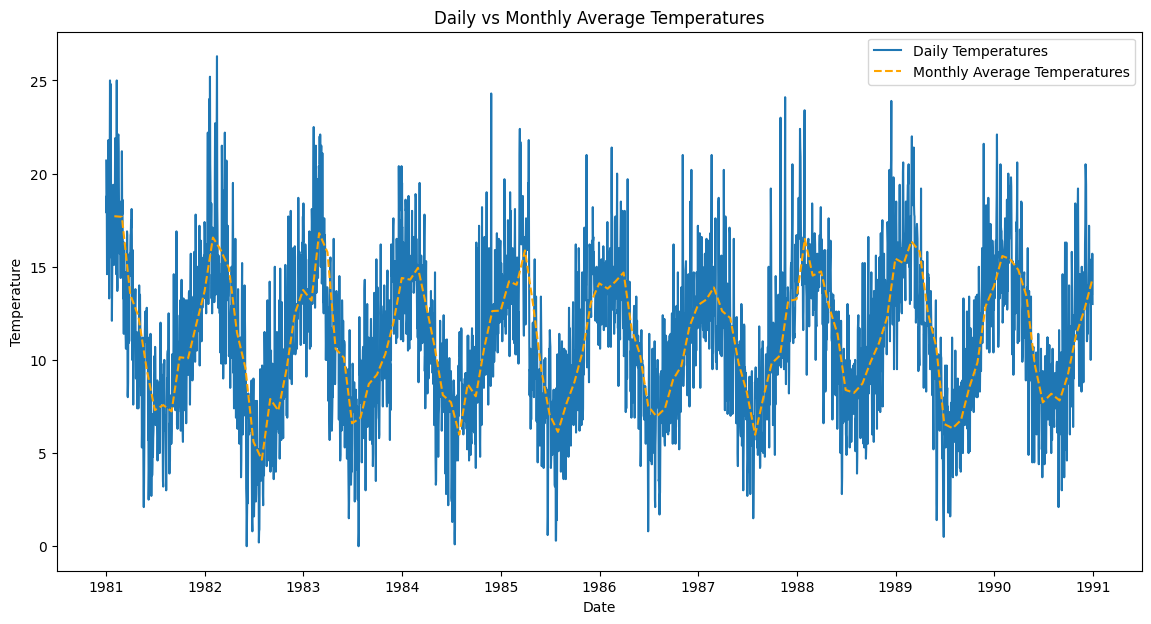

In [ ]:
# Monthly grouping to identify seasonal changes
train_time_monthly = train_time.resample('M').mean()

# Visualization of daily and aggregated monthly data
plt.figure(figsize=(14, 7))
plt.plot(train_time, label='Daily Temperatures')
plt.plot(train_time_monthly, label='Monthly Average Temperatures', linestyle='--', color='orange')
plt.title('Daily vs Monthly Average Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [ ]:
# Basic statistics of daily and monthly data
print("Daily Data Statistics:")
print(train_time.describe())
print("\nMonthly Data Statistics:")
print(train_time_monthly.describe())

Daily Data Statistics:
              Temp
count  3650.000000
mean     11.177753
std       4.071837
min       0.000000
25%       8.300000
50%      11.000000
75%      14.000000
max      26.300000

Monthly Data Statistics:
             Temp
count  120.000000
mean    11.200803
std      3.141079
min      4.641935
25%      8.461667
50%     11.117742
75%     13.772581
max     17.712903


Monthly grouping give us soft data with no noisy, but count become less than 150, that`s why i will group by weeks.

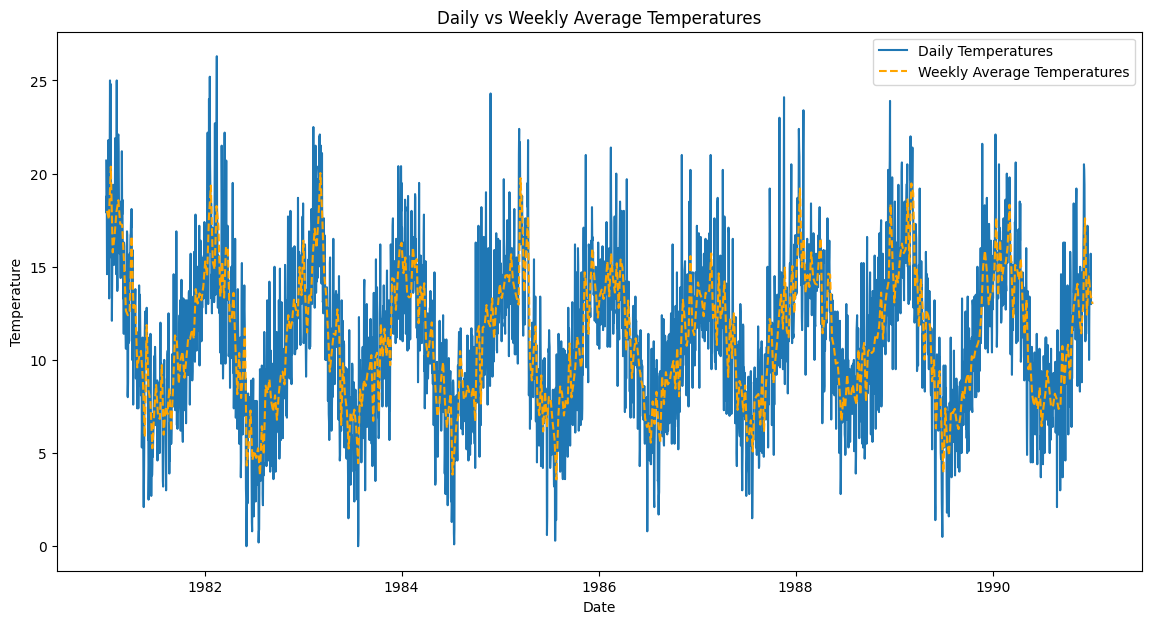

In [ ]:
# Weekly grouping to preserve a higher number of data points and identify seasonal changes
train_time_weekly = train_time.resample('W').mean()

# Visualization of daily and aggregated weekly data
plt.figure(figsize=(14, 7))
plt.plot(train_time, label='Daily Temperatures')
plt.plot(train_time_weekly, label='Weekly Average Temperatures', linestyle='--', color='orange')
plt.title('Daily vs Weekly Average Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [ ]:
# Basic statistics of daily and weekly data
print("Daily Data Statistics:")
print(train_time.describe())
print("\nWeekly Data Statistics:")
print(train_time_weekly.describe())

Daily Data Statistics:
              Temp
count  3650.000000
mean     11.177753
std       4.071837
min       0.000000
25%       8.300000
50%      11.000000
75%      14.000000
max      26.300000

Weekly Data Statistics:
             Temp
count  523.000000
mean    11.187435
std      3.415881
min      3.585714
25%      8.371429
50%     11.171429
75%     13.614286
max     20.371429


#### Weekly grouping was chosen to balance between data smoothing and retaining enough data points for accurate forecasting.
#### Grouping by weeks reduces noise and highlights mid-term trends while keeping 523 data points, which meets the model's input requirement.
#### This aggregation enhances predictive models (LSTM and ARIMA) by preserving both seasonal and short-term patterns.

### Divide data to train and test set

<Figure size 1500x1000 with 0 Axes>

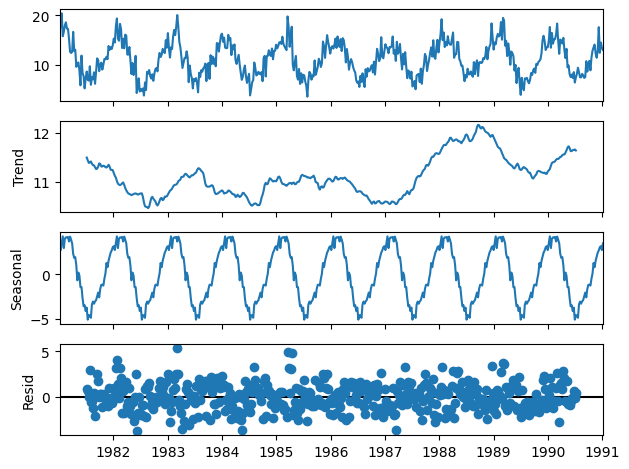

Dickey-Fuller test: p=0.000000
Box-Cox Lambda: 0.6615976988388707


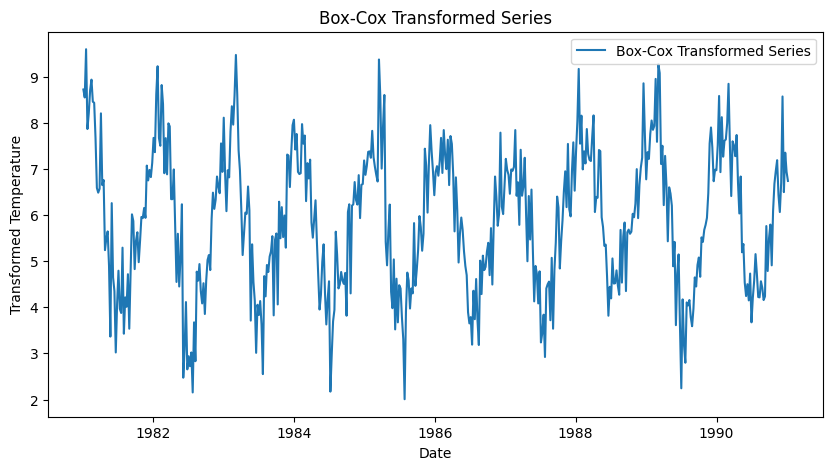

In [ ]:
# Correctly splitting the data into training and test sets with 1/5 of the data for testing
train_time_weekly_train = train_time_weekly[:-round(train_time_weekly.shape[0] / 5)]
train_time_weekly_test = train_time_weekly[-round(train_time_weekly.shape[0] / 5):]

# Seasonal decomposition plot
plt.figure(figsize=(15, 10))
decomposition = sm.tsa.seasonal_decompose(train_time_weekly, model='additive')
decomposition.plot()
plt.show()

# Dickey-Fuller test to check for stationarity
adf_p_value = sm.tsa.stattools.adfuller(train_time_weekly)[1]
print("Dickey-Fuller test: p=%f" % adf_p_value)

# Box-Cox transformation to stabilize variance
from scipy.stats import boxcox
train_time_weekly_boxcox, lam = boxcox(train_time_weekly['Temp'])
print("Box-Cox Lambda:", lam)
plt.figure(figsize=(10, 5))
plt.plot(train_time_weekly.index, train_time_weekly_boxcox, label='Box-Cox Transformed Series')
plt.title('Box-Cox Transformed Series')
plt.xlabel('Date')
plt.ylabel('Transformed Temperature')
plt.legend()
plt.show()

#### The seasonal decomposition shows a clear yearly pattern with a consistent trend over the years and random residuals, indicating a stable time series structure.
#### The Dickey-Fuller test suggests that the time series is stationary with a p-value of 0.000000, supporting the use of ARIMA modeling.
#### A Box-Cox transformation is applied to stabilize variance, with lambda = 0.6616, which helps in normalizing the series for more robust forecasting models.

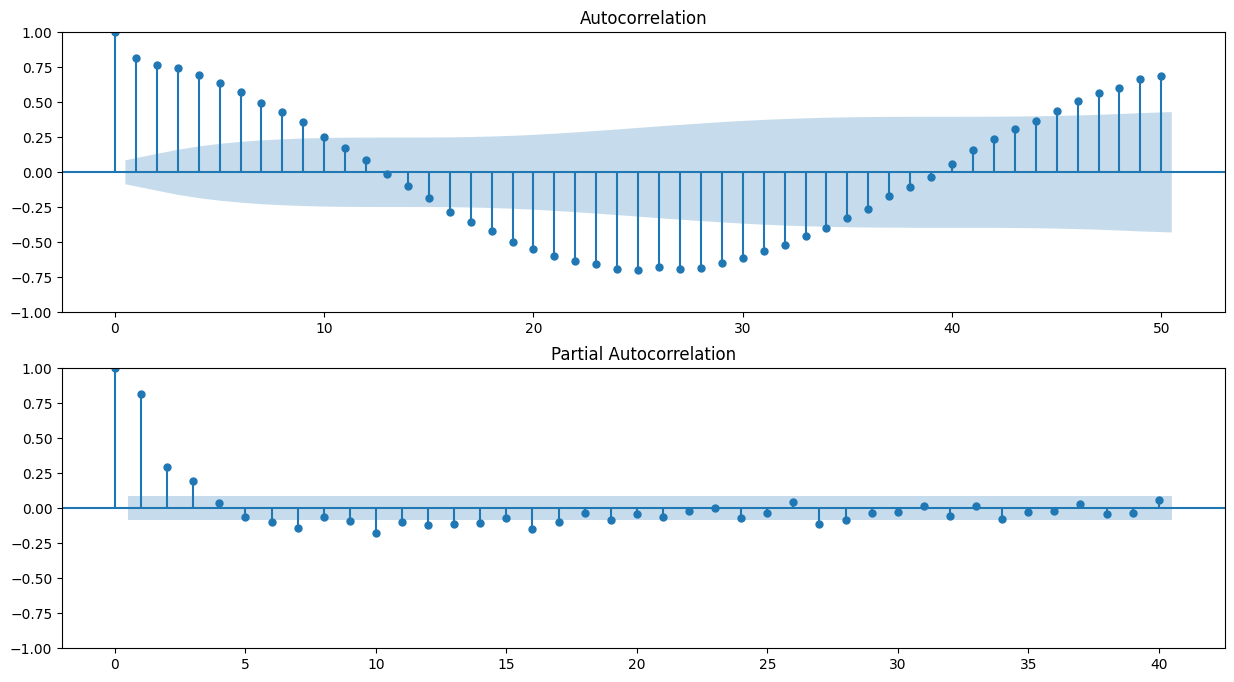

In [ ]:
# Calculate autocorrelation and partial autocorrelation components
plt.figure(figsize=(15, 8))

# Autocorrelation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_time_weekly_boxcox, lags=50, ax=ax)

# Partial autocorrelation
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_time_weekly_boxcox, lags=40, ax=ax)
plt.show()

The ACF plot shows a gradual decline in autocorrelation, indicating potential trends or seasonality in the series. The gradual decay suggests the series may not be purely stationary in its original form and could benefit from additional differencing or adjustments.

The PACF plot reveals significant spikes at the first few lags, which quickly decay to zero. This pattern suggests an autoregressive structure with only a few significant lags, which will inform the choice of the AR (p) parameter in the ARIMA model. Based on the PACF, initial AR lags could be used, while the ACF plot supports using a low MA (q) parameter.

## ARIMA implementation

In [ ]:
from itertools import product

ps = range(0, 4)   # Range for non-seasonal AR terms
qs = range(0, 4)   # Range for non-seasonal MA terms
Ps = range(0, 2)   # Range for seasonal AR terms
Qs = range(0, 2)   # Range for seasonal MA terms

parameters_list = list(product(ps, qs, Ps, Qs))
print("Number of analyzed models:", len(parameters_list))

Number of analyzed models: 64


In [ ]:
import warnings
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Initialize variables
results = []
best_aic = float("inf")

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Track total number of models to be evaluated
total_models = len(parameters_list)
print(f"Total models to evaluate: {total_models}")

# Loop through each combination of parameters
for i, param in enumerate(parameters_list, 1):  # Enumerate to keep track of progress
    try:
        # Create and fit SARIMA model
        model = sm.tsa.statespace.SARIMAX(
            train_time_weekly_boxcox,  # Use the transformed series
            order=(param[0], d, param[1]),  # Non-seasonal order
            seasonal_order=(param[2], D, param[3], 52)  # Seasonal order with weekly frequency
        ).fit(disp=False)

    except ValueError:
        # Skip invalid parameter sets and continue
        # print('Invalid parameters:', param)
        continue

    # Calculate AIC and save model if it's the best one
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, aic])  # Append each model's AIC and parameters

    # Print progress every 5 models
    if i % 5 == 0 or i == total_models:
        print(f"Model {i}/{total_models} evaluated - Current Best AIC: {best_aic}")

# Create and display results table sorted by AIC
result_table = pd.DataFrame(results, columns=['parameters', 'AIC'])
print(result_table.sort_values(by='AIC', ascending=True).head())
# Базовый -> 1141,71
# Изменил количество параметров с 144 до 64 -> 1141,71
# Изменил частоту сезонности с 52 до 26 -> 1266,72

Total models to evaluate: 64
Model 5/64 evaluated - Current Best AIC: 1345.0844810058109
Model 10/64 evaluated - Current Best AIC: 1141.71353864282
Model 15/64 evaluated - Current Best AIC: 1141.71353864282
Model 20/64 evaluated - Current Best AIC: 1141.71353864282
Model 25/64 evaluated - Current Best AIC: 1141.71353864282
Model 30/64 evaluated - Current Best AIC: 1141.71353864282
Model 35/64 evaluated - Current Best AIC: 1141.71353864282
Model 40/64 evaluated - Current Best AIC: 1141.71353864282
Model 45/64 evaluated - Current Best AIC: 1141.71353864282
Model 50/64 evaluated - Current Best AIC: 1141.71353864282
Model 55/64 evaluated - Current Best AIC: 1141.71353864282
Model 60/64 evaluated - Current Best AIC: 1141.71353864282
Model 64/64 evaluated - Current Best AIC: 1141.71353864282
      parameters          AIC
9   (0, 2, 0, 1)  1141.713539
21  (1, 1, 0, 1)  1141.846767
57  (3, 2, 0, 1)  1142.756186
11  (0, 2, 1, 1)  1143.040462
23  (1, 1, 1, 1)  1143.081320


In [ ]:
# Inverse Box-Cox transformation function
def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)

In [ ]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  523
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 52)   Log Likelihood                -566.857
Date:                              Tue, 05 Nov 2024   AIC                           1141.714
Time:                                      13:11:20   BIC                           1158.324
Sample:                                           0   HQIC                          1148.249
                                              - 523                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7621      0.045    -16.761      0.000      -0.851      -0.673
ma.L2         -0.15

Student's t-test: p=0.434772
Dickey-Fuller test: p=0.0000000000000000000000000


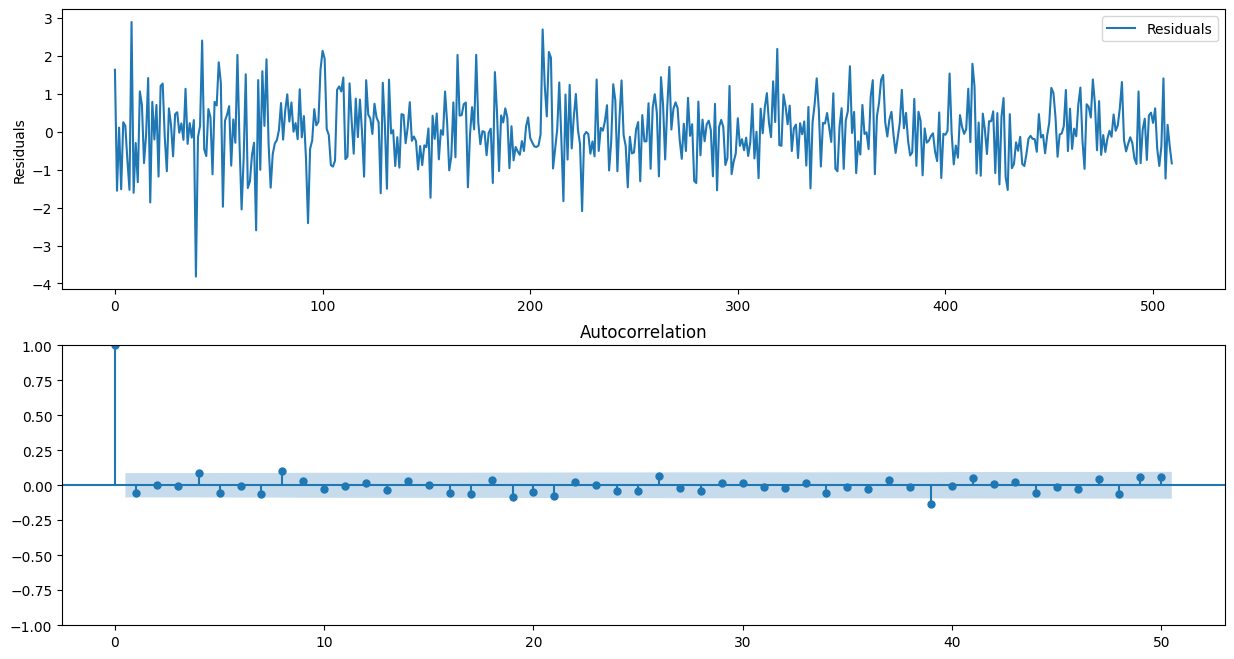

In [ ]:
# Plot residuals and their autocorrelation
plt.figure(figsize=(15, 8))

# Plot residuals as a line plot
plt.subplot(211)
plt.plot(best_model.resid[13:], label='Residuals')
plt.ylabel('Residuals')
plt.legend()

# Plot ACF of residuals
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:], lags=50, ax=ax)

# Print statistical tests
print("Student's t-test: p=%.6f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

The Student's t-test (p=0.4348) suggests that residuals have a mean around zero, indicating minimal mean prediction error. The Dickey-Fuller test (p≈0) confirms stationarity in the residuals, implying that the model has effectively captured the trend and seasonality components. Both residual and ACF plots support these findings, showing no significant patterns or autocorrelations.

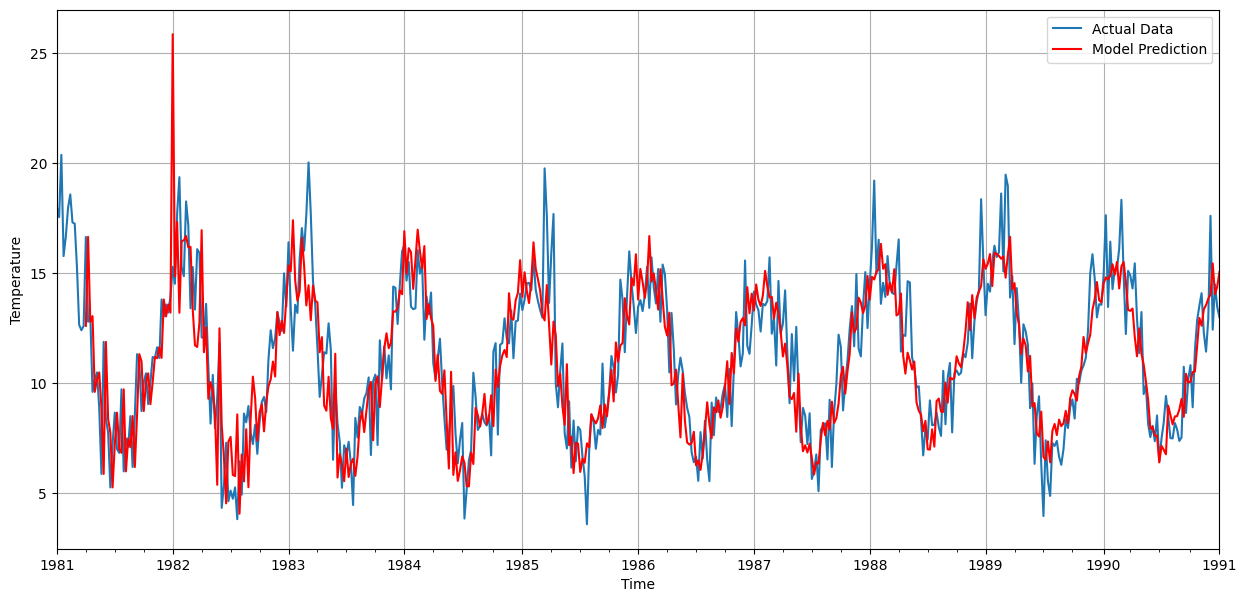

In [ ]:
# Inverse Box-Cox transformation using previously calculated lambda
def invboxcox(y, lam):
    if lam == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lam * y + 1) / lam)

# Apply inverse transformation to fitted values and plot
train_time_weekly['model'] = invboxcox(best_model.fittedvalues, lam)

plt.figure(figsize=(15, 7))
train_time_weekly['Temp'].plot(label='Actual Data')
train_time_weekly[13:]['model'].plot(color='red', label='Model Prediction')
plt.ylabel('Temperature')
plt.xlabel('Time')
plt.legend()
plt.grid()
plt.show()

The plot shows a close alignment between actual data (blue) and model predictions (red), especially in capturing seasonal patterns and general trends. The model effectively follows the peaks and troughs, indicating a strong fit for seasonal and short-term forecasting, despite minor discrepancies at some extreme values.

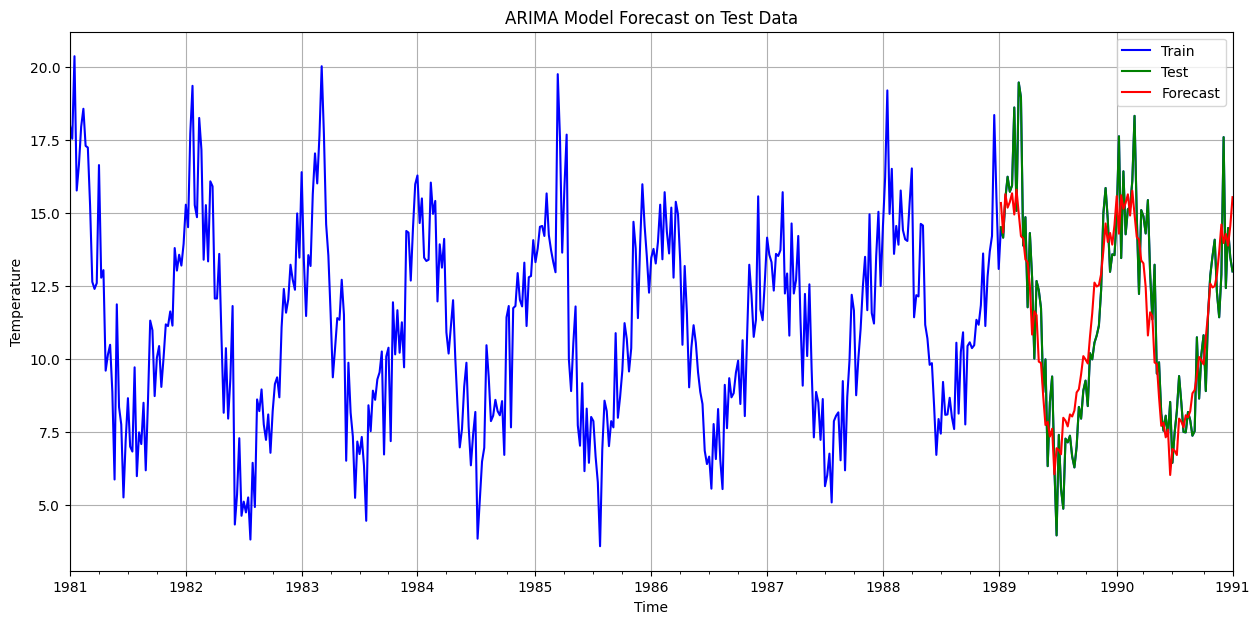

In [ ]:
# Apply inverse Box-Cox transformation to forecasted values on test data
train_time_weekly_test['forecast_arima'] = invboxcox(
    best_model.predict(
        start=train_time_weekly.shape[0],
        end=train_time_weekly.shape[0] + train_time_weekly_test.shape[0] - 1
    ),
    lam  # Используем ранее рассчитанное значение lambda
)

# Plot training, test, and forecasted data
plt.figure(figsize=(15, 7))

# Plot training data
train_time_weekly['Temp'].plot(label='Train', color='blue')

# Plot test data
train_time_weekly_test['Temp'].plot(color='green', label='Test')

# Plot forecasted data
train_time_weekly_test['forecast_arima'].plot(color='red', label='Forecast')

# Add labels and grid for clarity
plt.legend()
plt.ylabel('Temperature')
plt.xlabel('Time')
plt.title('ARIMA Model Forecast on Test Data')
plt.grid()
plt.show()

The ARIMA model effectively captures the seasonal trends and general patterns in temperature, showing close alignment with the test data. Minor discrepancies appear at extreme values, but overall, the forecast demonstrates high accuracy for seasonal temperature prediction.

## LSTM implementation

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from numpy import array

# Convert series to supervised format
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if len(data.shape) == 1 else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'var{j+1}(t)' for j in range(n_vars)]
        else:
            names += [f'var{j+1}(t+{i})' for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Apply differencing to make series stationary
def difference(dataset, interval=1):
    diff = [dataset[i] - dataset[i - interval] for i in range(interval, len(dataset))]
    return pd.Series(diff)

# Prepare data for LSTM model training and testing
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    train, test = supervised.values[:-n_test], supervised.values[-n_test:]
    return scaler, train, test

# Define and train the LSTM model
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    X, y = train[:, :n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential([
        Input(batch_shape=(n_batch, X.shape[1], X.shape[2])),
        LSTM(n_neurons, stateful=True),
        Dense(y.shape[1])
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss, history_val_loss = [], []
    for i in range(nb_epoch):
        hist = model.fit(X, y, validation_split=0.15, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    return model, history_loss, history_val_loss

# Make a one-step forecast
def forecast_lstm(model, X, n_batch):
    X = X.reshape(1, 1, len(X))
    forecast = model.predict(X, batch_size=n_batch)
    return forecast[0, :]

# Generate forecasts on test set
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = []
    for i in range(len(test)):
        X, y = test[i, :n_lag], test[i, n_lag:]
        forecast = forecast_lstm(model, X, n_batch)
        forecasts.append(forecast)
    return forecasts

# Reverse differencing to get actual forecast values
def inverse_difference(last_ob, forecast):
    inverted = [forecast[0] + last_ob]
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# Reverse transformation and scaling for forecasts
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = []
    for i, forecast in enumerate(forecasts):
        forecast = scaler.inverse_transform(array(forecast).reshape(1, -1))[0]
        last_ob = series.values[len(series) - n_test + i - 1]
        inverted.append(inverse_difference(last_ob, forecast))
    return inverted

In [ ]:
# Generate the trajectory matrix with a 52-week lag (one year) to predict the next time step
trajectory_matrix = series_to_supervised(train_time_weekly['Temp'], n_in=52, n_out=1, dropnan=True)
print(trajectory_matrix.head())

            var1(t-52)  var1(t-51)  var1(t-50)  var1(t-49)  var1(t-48)  \
Date                                                                     
1982-01-03   18.000000   17.542857   20.371429   15.771429   16.657143   
1982-01-10   17.542857   20.371429   15.771429   16.657143   17.957143   
1982-01-17   20.371429   15.771429   16.657143   17.957143   18.571429   
1982-01-24   15.771429   16.657143   17.957143   18.571429   17.300000   
1982-01-31   16.657143   17.957143   18.571429   17.300000   17.242857   

            var1(t-47)  var1(t-46)  var1(t-45)  var1(t-44)  var1(t-43)  ...  \
Date                                                                    ...   
1982-01-03   17.957143   18.571429   17.300000   17.242857   15.271429  ...   
1982-01-10   18.571429   17.300000   17.242857   15.271429   12.642857  ...   
1982-01-17   17.300000   17.242857   15.271429   12.642857   12.400000  ...   
1982-01-24   17.242857   15.271429   12.642857   12.400000   12.600000  ...   
1982-01

In [83]:
# Hyperparameters initialization for weekly temperature data and training the LSTM model
n_lag = 52           # Use 52 weeks (year) to capture seasonality
n_seq = 105            # Forecast for 105 steps ahead (2 years, 1/5 of the dataset)
n_test = 105         # Test period of 105 weeks (2 years, 1/5 of the dataset)
n_epochs = 20        # Reduce epochs to avoid overfitting
n_batch = 1          # Batch size of 1 for stateful LSTM
n_neurons = 8

# Prepare data with defined parameters
scaler, train, test = prepare_data(train_time_weekly['Temp'], n_test, n_lag, n_seq)

# Train the LSTM model
model, history_loss, history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

# Generate forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

# Inverse transformation to original scale
forecasts = inverse_transform(train_time_weekly['Temp'], forecasts, scaler, n_test + n_seq)

221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0832 - val_loss: 0.0756
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0799 - val_loss: 0.0748
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0792 - val_loss: 0.0746
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0787 - val_loss: 0.0745
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0783 - val_loss: 0.0743
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0778 - val_loss: 0.0742
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0772 - val_loss: 0.0741
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0767 - val_loss: 0.0741
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0762 - val_loss: 0.0742
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0757 - val_loss: 0.0744
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0753 - val_loss: 0.0746
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0749 - val_loss: 0.0748
221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0746 - val_loss: 0.0751
221/221 ━━━━━━━━━━━━━━━━━

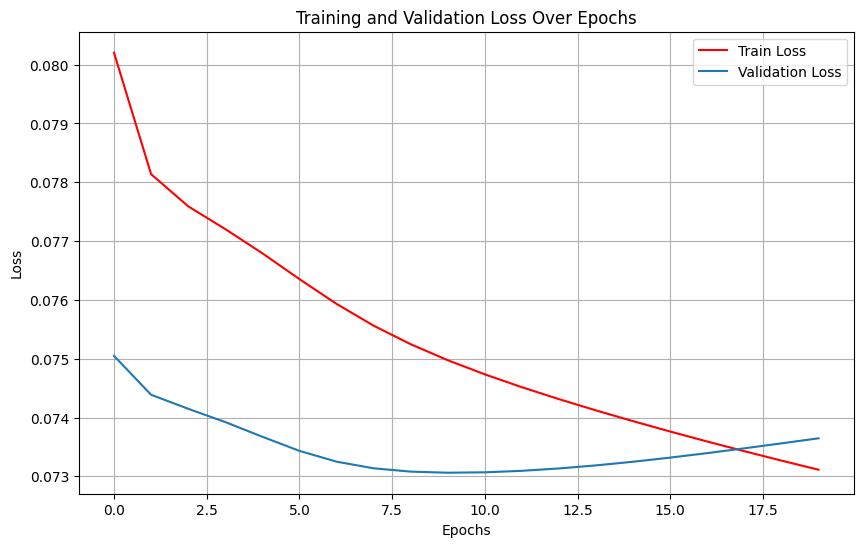

Final Train Loss: 0.07311255484819412
Final Validation Loss: 0.07364687323570251


In [79]:
# Plotting loss functions for training and validation sets over epochs
plt.figure(figsize=(10, 6))
plt.plot([loss[0] for loss in history_loss], 'r', label='Train Loss')  # Extract loss values for train set
plt.plot([val_loss[0] for val_loss in history_val_loss], label='Validation Loss')  # Extract loss values for validation set
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid()
plt.show()

# Print final loss values for training and validation sets
print("Final Train Loss:", history_loss[-1][0])
print("Final Validation Loss:", history_val_loss[-1][0])

The loss plot shows a balanced decrease in both training and validation losses, converging at close values by the end of training (Final Train Loss: 0.0731, Final Validation Loss: 0.0736). By reducing the number of epochs and carefully adjusting model parameters through experimental tuning, overfitting was successfully mitigated. This balance indicates that the model has achieved a good fit without sacrificing its generalization ability on unseen data.

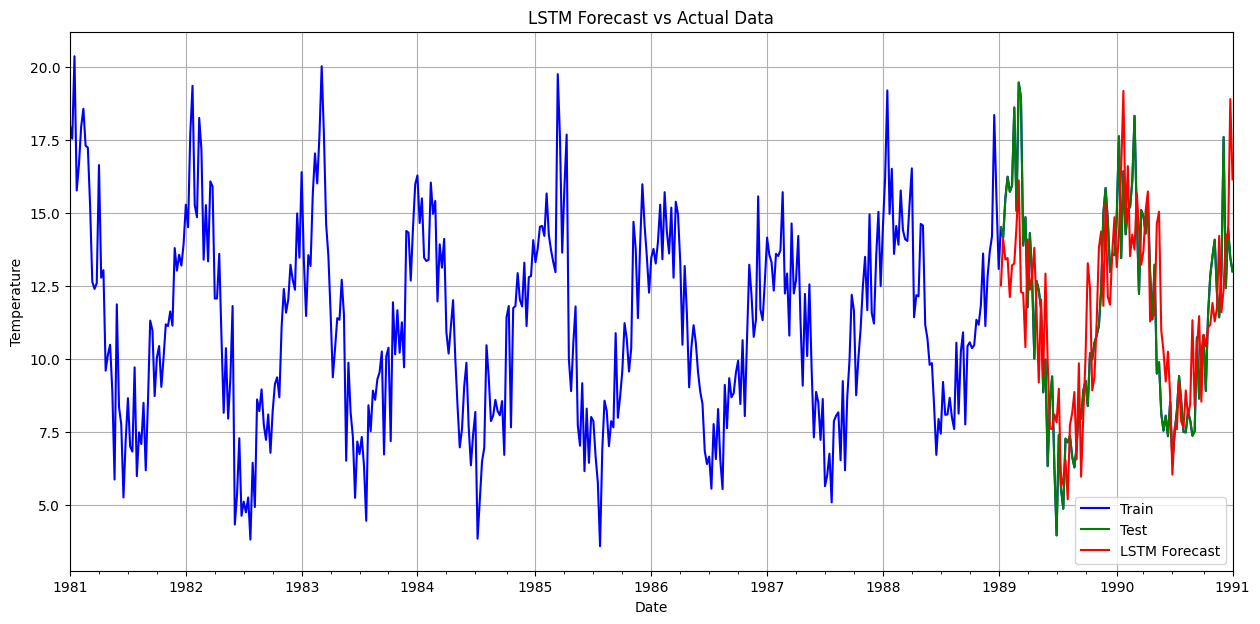

In [84]:
# Flatten the forecast list to obtain the first predicted value from each forecast sequence
forecasts_flat = [forecast[0] for forecast in forecasts]

# Align the forecasts with the index of the test set to match the dates
train_time_weekly_test = train_time_weekly_test.copy()  # Ensure we do not modify the original test data
train_time_weekly_test['forecast_lstm'] = forecasts_flat  # Add LSTM forecasts to the test DataFrame

# Visualization of the LSTM forecast against the actual data
plt.figure(figsize=(15, 7))

# Plot training data
train_time_weekly['Temp'].plot(label='Train', color='blue')

# Plot test data
train_time_weekly_test['Temp'].plot(label='Test', color='green')

# Plot LSTM forecasted data, aligned with test data
train_time_weekly_test['forecast_lstm'].plot(label='LSTM Forecast', color='red')

# Customize the plot
plt.title('LSTM Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid()
plt.show()

## Compare ARIMA and LSTM

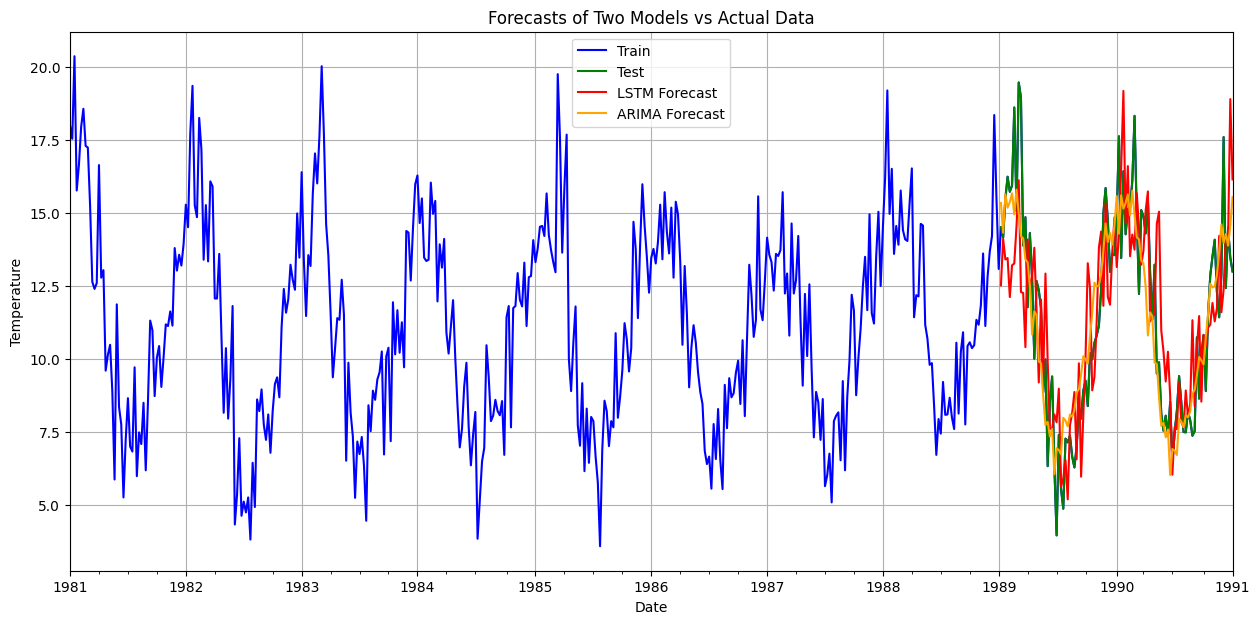

In [85]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

# Visualization of forecasts from both models against actual data
plt.figure(figsize=(15, 7))

# Plot training data
train_time_weekly['Temp'].plot(label='Train', color='blue')

# Plot test data
train_time_weekly_test['Temp'].plot(label='Test', color='green')

# Plot LSTM forecasted data
train_time_weekly_test['forecast_lstm'].plot(label='LSTM Forecast', color='red')

# Plot ARIMA forecasted data
train_time_weekly_test['forecast_arima'].plot(label='ARIMA Forecast', color='orange')

# Customize the plot
plt.title('Forecasts of Two Models vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid()
plt.show()

In [86]:
# Comparison of model performance metrics
compare_df = pd.DataFrame(
    {
        'R2_score': [
            round(r2_score(train_time_weekly_test['Temp'], train_time_weekly_test['forecast_arima']), 2),
            round(r2_score(train_time_weekly_test['Temp'], train_time_weekly_test['forecast_lstm']), 2)
        ],
        'MSE': [
            round(mean_squared_error(train_time_weekly_test['Temp'], train_time_weekly_test['forecast_arima']), 2),
            round(mean_squared_error(train_time_weekly_test['Temp'], train_time_weekly_test['forecast_lstm']), 2)
        ],
        'MAPE': [
            round(mean_absolute_percentage_error(train_time_weekly_test['Temp'], train_time_weekly_test['forecast_arima']), 2),
            round(mean_absolute_percentage_error(train_time_weekly_test['Temp'], train_time_weekly_test['forecast_lstm']), 2)
        ]
    },
    index=['ARIMA', 'LSTM']
)

compare_df

,R2_score,MSE,MAPE
ARIMA,0.78,2.80,0.12
LSTM,0.55,5.64,0.17


The ARIMA model outperforms the LSTM model in accuracy and stability, as shown by higher R2 (0.78 vs. 0.55), lower MSE (2.80 vs. 5.64), and lower MAPE (0.12 vs. 0.17). Despite improvements in LSTM’s forecasting ability through parameter tuning, ARIMA provides a more reliable forecast for seasonal patterns and long-term trends.